In [114]:
!pip install kagglehub==0.3.3

In [115]:
import kagglehub
import os
import pandas as pd
import numpy as np
import itertools
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense, Input
from tensorflow.keras.optimizers import Adam

In [152]:
# Download latest version of kaggle dataset
path = kagglehub.dataset_download("alistairking/recyclable-and-household-waste-classification")

In [153]:
# Get image paths and create lists to populate later
class_path = path + '/images' + '/images'
classes = os.listdir(class_path)
image_paths = []
labels = [] # Trash category associated with each image
d_r = [] # default (studio/standard) vs real world img


In [154]:
# Access image folders and populate lists with needed data
'''Arthur's shit
for i, label in enumerate(classes):
    class_dir = os.path.join(class_path, label)
    for subfolder in ['default', 'real_world']:
        subfolder_dir = os.path.join(class_dir, subfolder)
        image_names = os.listdir(subfolder_dir)
        
        for j in range(0, len(image_names), int(len(image_names)/3)): # TODO: change step on turn-in
          image_name = image_names[j]
          d_r.append(subfolder)
          image_paths.append(os.path.join(subfolder_dir, image_name)) 
          labels.append(label)
'''

"Arthur's shit\nfor i, label in enumerate(classes):\n    class_dir = os.path.join(class_path, label)\n    for subfolder in ['default', 'real_world']:\n        subfolder_dir = os.path.join(class_dir, subfolder)\n        image_names = os.listdir(subfolder_dir)\n        \n        for j in range(0, len(image_names), int(len(image_names)/3)): # TODO: change step on turn-in\n          image_name = image_names[j]\n          d_r.append(subfolder)\n          image_paths.append(os.path.join(subfolder_dir, image_name)) \n          labels.append(label)\n"

In [155]:
# Access image folders and populate lists with needed data
# Serena's shit
for i, label in enumerate(classes):
    class_dir = os.path.join(class_path, label)
    for subfolder in ['default', 'real_world']:
        subfolder_dir = os.path.join(class_dir, subfolder)
        image_names = os.listdir(subfolder_dir)
        
        for image_name in image_names:
            d_r.append(subfolder)
            image_paths.append(os.path.join(subfolder_dir, image_name))
            labels.append(label)

In [156]:
# Load all data into df
columnDict = {'image_path': image_paths, 'label': labels, 'default_vs_real_world': d_r}
df = pd.DataFrame(columnDict)
df.shape

(15000, 3)

## Clean Data

In [157]:
clean_df = df.copy()
clean_df.label.unique()
cat_dic = {
    'landfill' : ['clothing', 'disposable_plastic_cutlery', 'plastic_shopping_bags', 'plastic_trash_bags',\
                  'shoes', 'styrofoam_cups', 'styrofoam_food_containers', 'paper_cups', 'plastic_straws', 'plastic_cup_lids'],
    'recyclable' : ['aerosol_cans','aluminum_food_cans', 'aluminum_soda_cans', 'cardboard_boxes', 'cardboard_packaging', 'glass_beverage_bottles',\
                    'glass_cosmetic_containers', 'glass_food_jars', 'magazines', 'newspaper', 'office_paper', 'plastic_detergent_bottles',\
                    'plastic_food_containers','plastic_soda_bottles', 'plastic_water_bottles', 'steel_food_cans'],
    'compost' : ['coffee_grounds', 'eggshells', 'food_waste', 'tea_bags']
}

# Create a reverse lookup dictionary to map items to categories
item_to_category = {item: category for category, items in cat_dic.items() for item in items}

# Map the labels to respective categories using lookup dictionary
clean_df['category'] = df['label'].map(item_to_category)
clean_df.head()

,image_path,label,default_vs_real_world,category
0,C:\Users\S\.cache\kagglehub\datasets\alistairk...,aerosol_cans,default,recyclable
1,C:\Users\S\.cache\kagglehub\datasets\alistairk...,aerosol_cans,default,recyclable
2,C:\Users\S\.cache\kagglehub\datasets\alistairk...,aerosol_cans,default,recyclable
3,C:\Users\S\.cache\kagglehub\datasets\alistairk...,aerosol_cans,default,recyclable
4,C:\Users\S\.cache\kagglehub\datasets\alistairk...,aerosol_cans,default,recyclable


In [158]:
def subset(df, num):
    """
    Gets subset of dataframe. USE THIS FOR WORKING LOCALLY ONLY.

    ARGS:
        df: dataframe 
        num(float): decimal representing what amt of original df you wanna use for subset (eg. .5 or .3)
    RETURNS:
        df: smaller df that's shuffled
    """
    return df.sample(frac=num, random_state=42).reset_index(drop=True)
    
# CHANGE frac TO 1 WHEN USING SUPER COMPUTER 
frac = 0.1 #<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<
tiny_df = subset(clean_df, frac)
tiny_df.shape

(1500, 4)

In [159]:
def train_val_test(df):
    """
    Split df into train, val, test. HARDCODED to 60% train, 20% val and 20% test btw
    """
    # Get rid of unnecessary columns HARDCODED
    df = df[['image_path', 'category']]
    # Split into train and temp (40% for validation + test)
    train_df, temp_df = train_test_split(df, test_size=0.4, random_state=42)
    
    # Split temp into validation and test (10% each)
    val_df, test_df = train_test_split(df, test_size=0.5, random_state=42)
    
    print(f"Train size: {len(train_df)}, Validation size: {len(val_df)}, Test size: {len(test_df)}")
    return train_df, val_df, test_df

train_df, val_df, test_df = train_val_test(tiny_df)
train.head()

Train size: 900, Validation size: 750, Test size: 750


,image_path,category
1190,C:\Users\S\.cache\kagglehub\datasets\alistairk...,recyclable
3411,C:\Users\S\.cache\kagglehub\datasets\alistairk...,landfill
530,C:\Users\S\.cache\kagglehub\datasets\alistairk...,recyclable
2501,C:\Users\S\.cache\kagglehub\datasets\alistairk...,recyclable
49,C:\Users\S\.cache\kagglehub\datasets\alistairk...,landfill


In [167]:
def to_tensorflow(df, shuffle=True):
    """
    Convert pandas df to tensorflow dataset.
    ARGS:
        df: pandas df
    RETURNS 
        gen: tensorflow dataset
    """
    preprocess = tf.keras.applications.vgg16.preprocess_input # preprocessing function for CNN 
    target_size=(224,224) # set the size of the images
    color_mode='rgb' # set the type of image
    class_mode= 'categorical' # set the class mode
    batch_size=10  # set the batch size 
    gen=ImageDataGenerator(preprocessing_function=preprocess).flow_from_dataframe(df, 
          x_col='image_path',
          y_col='category', target_size=target_size, color_mode=color_mode,
          class_mode=class_mode, batch_size=batch_size, shuffle=shuffle)
    return gen
pandas_dfs = [train_df, val_df]
train_batches, val_batches = [to_tensorflow(df) for df in pandas_dfs]
test_batches = to_tensorflow(test_df, shuffle=False) # don't shuffle test batch

Found 900 validated image filenames belonging to 3 classes.
Found 750 validated image filenames belonging to 3 classes.
Found 750 validated image filenames belonging to 3 classes.


## Train and Validation

In [161]:
# generate batch of images and labels from training set
imgs, labels = next(train_batches)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-103.939..151.061].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-5.6800003..151.061].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-120.68..151.061].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-107.779..151.061].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-123.68..151.061].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-123.68..151.061].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-123.68..151.061].
Clipping input 

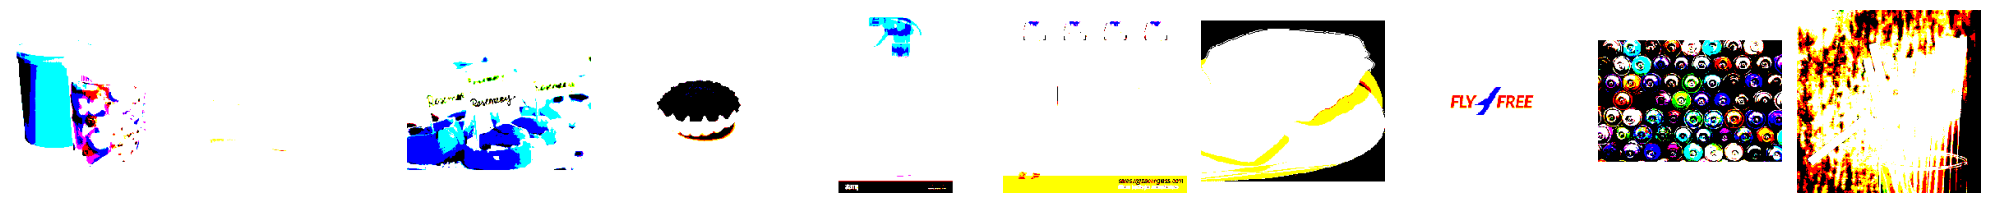

[[0. 0. 1.]
 [0. 1. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 0. 1.]
 [0. 1. 0.]]


In [162]:
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 10, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()
plotImages(imgs) # images look fucky because of the preprocessing function 
print(labels) # one hot encoding of categories

In [163]:
# Build CNN
model = Sequential([
    Input(shape=(224, 224, 3)),
    Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding = 'same'),
    MaxPool2D(pool_size=(2, 2), strides=2),
    Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding = 'same'),
    MaxPool2D(pool_size=(2, 2), strides=2),
    Flatten(),
    Dense(units=3, activation='softmax')
])
model.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_10 (Conv2D)                   │ (None, 224, 224, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_10 (MaxPooling2D)      │ (None, 112, 112, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_11 (Conv2D)                   │ (None, 112, 112, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_11 (MaxPooling2D)      │ (None, 56, 56, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_5 (Flatten)                  │ (None, 200704)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 3)                   │         602,115 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 621,507 (2.37 MB)

 Trainable params: 621,507 (2.37 MB)

 Non-trainable params: 0 (0.00 B)

In [164]:
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [165]:
history = model.fit(x=train_batches,
    steps_per_epoch=len(train_batches),
    validation_data=val_batches,
    validation_steps=len(val_batches),
    epochs=10,
    verbose=2,
    workers=-1
)

Epoch 1/10


C:\Users\S\anaconda3\envs\cse151a\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


90/90 - 40s - 443ms/step - accuracy: 0.4944 - loss: 54.4161 - val_accuracy: 0.6787 - val_loss: 4.7644
Epoch 2/10
90/90 - 44s - 494ms/step - accuracy: 0.6444 - loss: 5.3454 - val_accuracy: 0.8560 - val_loss: 0.8444
Epoch 3/10
90/90 - 36s - 398ms/step - accuracy: 0.8344 - loss: 0.8387 - val_accuracy: 0.8840 - val_loss: 0.4923
Epoch 4/10
90/90 - 26s - 292ms/step - accuracy: 0.9289 - loss: 0.2512 - val_accuracy: 0.9600 - val_loss: 0.1445
Epoch 5/10
90/90 - 27s - 300ms/step - accuracy: 0.9522 - loss: 0.2254 - val_accuracy: 0.9813 - val_loss: 0.0582
Epoch 6/10
90/90 - 28s - 307ms/step - accuracy: 0.9744 - loss: 0.0796 - val_accuracy: 0.9867 - val_loss: 0.0321
Epoch 7/10
90/90 - 37s - 414ms/step - accuracy: 0.9811 - loss: 0.0646 - val_accuracy: 0.9907 - val_loss: 0.0275
Epoch 8/10
90/90 - 33s - 366ms/step - accuracy: 0.9856 - loss: 0.0338 - val_accuracy: 0.9933 - val_loss: 0.0146
Epoch 9/10
90/90 - 32s - 353ms/step - accuracy: 0.9978 - loss: 0.0125 - val_accuracy: 0.9947 - val_loss: 0.0121
Ep

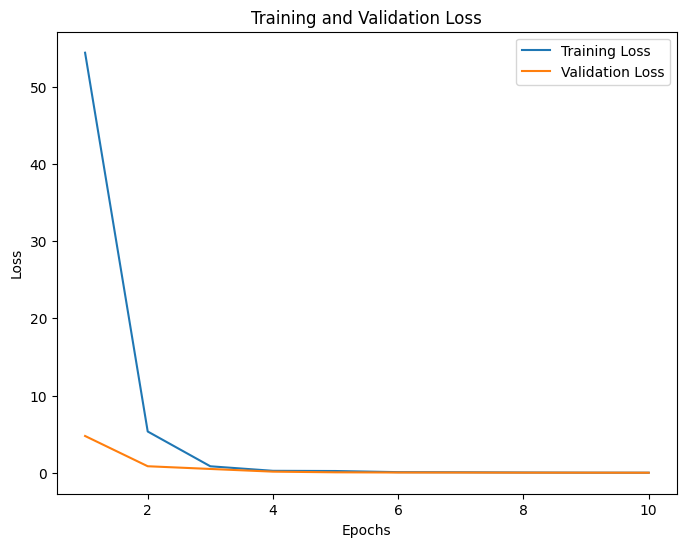

In [166]:
# Extract the training and validation loss from the history object
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Plot training and validation loss
plt.figure(figsize=(8, 6))
plt.plot(range(1, len(train_loss) + 1), train_loss, label='Training Loss')
plt.plot(range(1, len(val_loss) + 1), val_loss, label='Validation Loss')

# Adding labels and title
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Display the plot
plt.show()

## Predict on Test

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-114.779..151.061].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-120.68..151.061].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-123.68..151.061].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-121.68..151.061].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-110.68..151.061].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-123.68..151.061].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-117.68..151.061].
Clipping input data

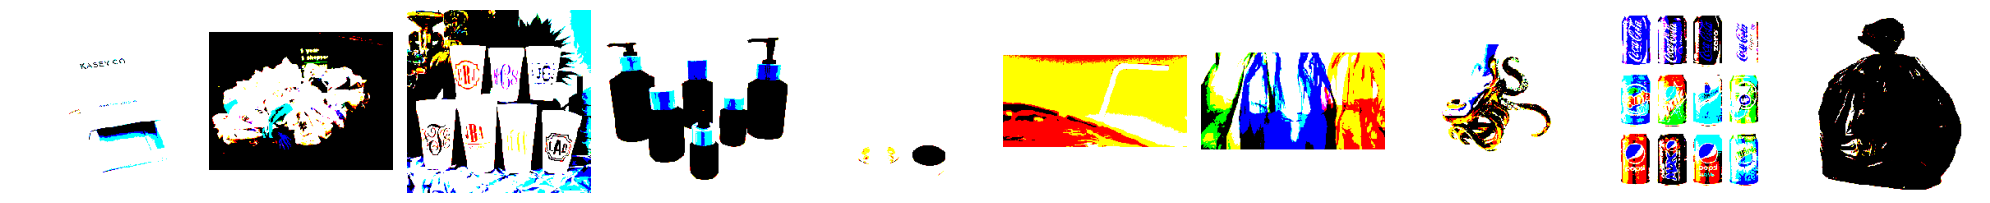

[[0. 0. 1.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 0. 1.]
 [0. 1. 0.]]


In [130]:
# Take a look at the test images
test_imgs, test_labels = next(test_batches)
plotImages(test_imgs)
print(test_labels)

In [140]:
predictions = model.predict(x=test_batches, steps=len(test_batches), verbose=0)

In [141]:
# Show predictions rounded
np.round(predictions) 

array([[0., 0., 1.],
       [0., 1., 0.],
       [0., 1., 0.],
       ...,
       [0., 1., 0.],
       [0., 0., 1.],
       [0., 1., 0.]], dtype=float32)

In [142]:
cm = confusion_matrix(y_true=test_batches.classes, y_pred=np.argmax(predictions, axis=-1))

In [149]:
# True y
# test_batches.classes

In [144]:
# CODE COPIED FROM SCI-KIT LEARN
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [145]:
test_batches.class_indices

{'compost': 0, 'landfill': 1, 'recyclable': 2}

Confusion matrix, without normalization
[[ 69  14  25]
 [ 25 141  80]
 [ 23  72 301]]


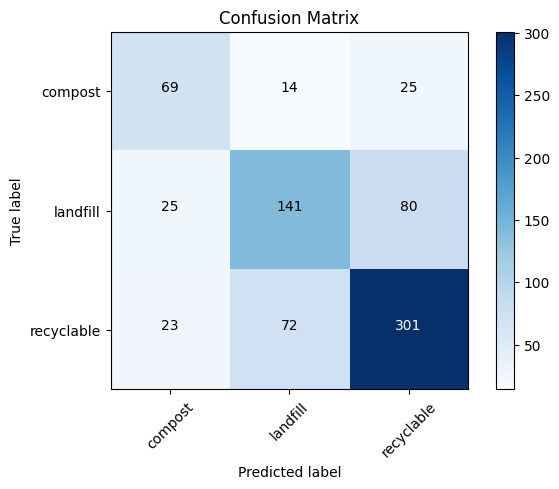

In [146]:
cm_plot_labels = ['compost','landfill', 'recyclable']
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title='Confusion Matrix')

In [138]:
loss, accuracy = model.evaluate(test_batches.classes, )

print(f'Test Loss: {loss}')
print(f'Test Accuracy: {accuracy * 100:.2f}%')

75/75 ━━━━━━━━━━━━━━━━━━━━ 10s 135ms/step - accuracy: 0.6303 - loss: 3.4238
Test Loss: 2.9792397022247314
Test Accuracy: 68.13%
